In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [196]:
data = pd.read_csv('presidential_elections.csv')
data

,year,office,state,district,election_date,forecast_date,forecast_type,party,candidate,projected_voteshare,actual_voteshare,probwin,probwin_outcome
0,2020,President,WY,NaN,2020-11-03,2020-11-03,polls-plus,R,Trump,65.77760,69.936227,0.998375,1
1,2020,President,WY,NaN,2020-11-03,2020-11-03,polls-plus,D,Biden,31.04658,26.553574,0.001625,0
2,2020,President,WI,NaN,2020-11-03,2020-11-03,polls-plus,R,Trump,45.37802,48.822437,0.056425,0
3,2020,President,WI,NaN,2020-11-03,2020-11-03,polls-plus,D,Biden,53.68898,49.449537,0.943575,1
4,2020,President,WV,NaN,2020-11-03,2020-11-03,polls-plus,R,Trump,64.48556,68.628270,0.992825,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106965,2008,President,WI,NaN,2008-11-04,2008-11-04,NaN,R,NaN,NaN,NaN,0.000100,0
106966,2008,President,WY,NaN,2008-11-04,2008-11-04,NaN,D,NaN,NaN,NaN,0.000100,0
106967,2008,President,WY,NaN,2008-11-04,2008-11-04,NaN,R,NaN,NaN,NaN,0.999900,1
106968,2008,President,US,NaN,2008-11-04,2008-11-04,NaN,D,NaN,NaN,NaN,0.989000,1


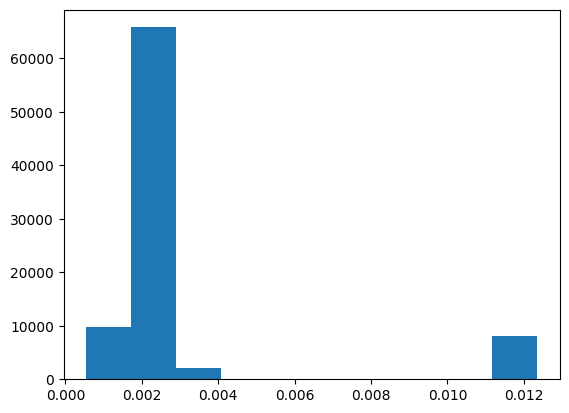

In [197]:
# just in case any 0 or 100% probabilities were included in the dataset given they say, "We have removed all 100 percent and 0 percent forecasts for events that were guaranteed or impossible from this analysis; for example, any forecasts made after a team was eliminated from a postseason race or forecasts for uncontested elections that were not on the ballot." https://projects.fivethirtyeight.com/checking-our-work/presidential-elections/
df = data[(data['probwin'] > 0) & (data['probwin'] < 1)]

# "When calculating the calibration and skill scores for forecasts that we updated over time, such as election forecasts that we updated every day, we weighted each update by the inverse of the number of updates issued. That way, we counted each forecasted event equally, regardless of how many updates we issued to the forecast. We applied the same weights when calculating the confidence intervals." https://projects.fivethirtyeight.com/checking-our-work/presidential-elections/

df = df.copy()  # Avoid SettingWithCopyWarning by creating a copy
df['weight'] = df.groupby(['year', 'state', 'candidate'])['probwin'].transform('count')
df['weight'] = 1 / df['weight']
df.dropna(subset=['weight'], inplace=True)
plt.hist(df['weight'])
plt.show()

# Calibration Plot

In [198]:
bins = np.linspace(0, 1, 21)
df['prob_bin'] = pd.cut(df['probwin'], bins, include_lowest=True)
grouped = df.groupby('prob_bin', observed=False)

In [199]:
def calculate_calibration(group):
    if len(group) == 0:
        return pd.Series({'mean_pred_prob': np.nan, 'actual_outcome': np.nan, 'count': 0})
    mean_pred_prob = np.average(group['probwin'], weights=group['weight'])
    actual_outcome = np.average(group['probwin_outcome'], weights=group['weight'])
    count = group['probwin'].count()
    return pd.Series({'mean_pred_prob': mean_pred_prob, 'actual_outcome': actual_outcome, 'count': count})

In [200]:
calibration = grouped.apply(calculate_calibration).reset_index()

/var/folders/00/5h0ls8v57z52470dh9jw256r0000gn/T/ipykernel_5413/1279863919.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration = grouped.apply(calculate_calibration).reset_index()


In [201]:
def bootstrap_ci(data, weights, n_bootstraps=1000, ci=95):
    bootstraps = np.random.choice(data, (n_bootstraps, len(data)), replace=True, p=weights/weights.sum())
    stats = np.mean(bootstraps, axis=1)
    lower_bound = np.percentile(stats, (100 - ci) / 2)
    upper_bound = np.percentile(stats, 100 - (100 - ci) / 2)
    return lower_bound, upper_bound

In [202]:
calibration['lower_ci'], calibration['upper_ci'] = zip(*calibration.apply(
    lambda row: bootstrap_ci(df[df['prob_bin'] == row['prob_bin']]['probwin_outcome'], 
                             df[df['prob_bin'] == row['prob_bin']]['weight']), axis=1))

In [203]:
calibration['point_size'] = calibration['count'] / calibration['count'].max() * 50

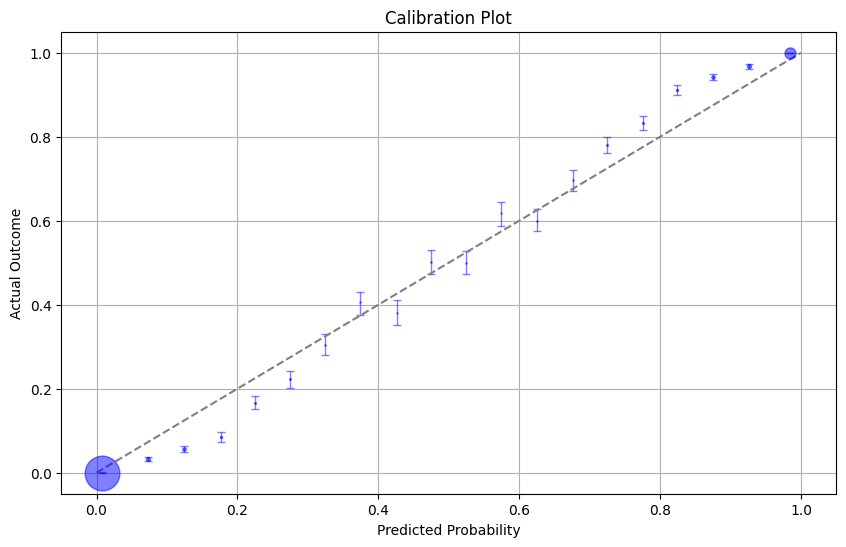

In [204]:
plt.figure(figsize=(10, 6))

for idx, row in calibration.iterrows():
    if pd.notna(row['lower_ci']) and pd.notna(row['upper_ci']):
        plt.errorbar(row['mean_pred_prob'], row['actual_outcome'], 
                     yerr=[[row['actual_outcome'] - row['lower_ci']], [row['upper_ci'] - row['actual_outcome']]],
                     fmt='o', markersize=row['point_size']*0.5, alpha=0.5, color='blue', capsize=3, capthick=1, elinewidth=1)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Outcome')
plt.title('Calibration Plot')
plt.grid(True)
plt.show()

# Brier Skill Score

In [205]:
df.dropna(subset=['weight', 'probwin', 'probwin_outcome'], inplace=True)

In [206]:
# brier score
def brier_score(forecasts, outcomes, weights):
    return np.average((forecasts - outcomes) ** 2, weights=weights)

# reference brier score
def reference_brier_score(outcomes, weights):
    o_bar = np.average(outcomes, weights=weights)
    return np.average((o_bar - outcomes) ** 2, weights=weights)

# rrier skill score
def brier_skill_score(forecasts, outcomes, weights):
    bs = brier_score(forecasts, outcomes, weights)
    bs_ref = reference_brier_score(outcomes, weights)
    return 1 - (bs / bs_ref)

In [207]:
forecasts = df['probwin']
outcomes = df['probwin_outcome']
weights = df['weight']

bss = brier_skill_score(forecasts, outcomes, weights)
print(bss)

0.7776970004538503
